<a href="https://colab.research.google.com/github/mxn170019/Ieee_Fraud-Detection-Kaggle-competition/blob/master/ieeeFraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Dictionary


## Transaction Table *
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
## Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

# Identity Table *
- Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
- They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

## Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

# Import required libraries

In [5]:
import os
import glob
from pathlib import Path
import zipfile
import gc

import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

from ipywidgets import widgets, interactive
from ipykernel.pylab.backend_inline import flush_figures

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,precision_score,precision_recall_curve,f1_score,confusion_matrix,accuracy_score,roc_auc_score,roc_curve

from sklearn.model_selection import KFold
import lightgbm as lgb

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50000)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings("ignore")


# data directory

In [6]:
# Attaching Drive to colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"mxn170019","key":"3a67e29bb92b34ac3c0d8fadd0dfb4bc"}'}

In [7]:
!pip install -q kaggle
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
# !kaggle datasets list -s skin
!kaggle competitions download -c ieee-fraud-detection

-rw-r--r-- 1 root root 65 Nov  8 02:03 kaggle.json
train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
ls = glob.glob("*.zip")
for item in ls:
  zipfile.ZipFile(item).extractall()

!rm *.zip

In [0]:
# Define path to the data directory
data_dir = Path('')

train_transaction_dir = data_dir / 'train_transaction.csv'
train_identity_dir = data_dir / 'train_identity.csv'

test_transaction_dir = data_dir / 'test_transaction.csv'
test_identity_dir = data_dir / 'test_identity.csv'

sample_submission = data_dir/'sample_submission.csv'

# Read Data Files

In [0]:
#let see how should be the submission file
sample_submission = pd.read_csv(sample_submission)
test_tran_df = pd.read_csv(test_transaction_dir)
test_identity_df = pd.read_csv(test_identity_dir)
train_tran_df = pd.read_csv(train_transaction_dir)
train_identity_df = pd.read_csv(train_identity_dir)

In [0]:
#Joining Tables
train_df = pd.merge(train_tran_df, train_identity_df, on='TransactionID', how='left')
test_df = pd.merge(test_tran_df, test_identity_df, on='TransactionID', how='left')

# EDA

## EDA - Transaction Data

In [12]:
#faud and non fraund franction
np.round(train_tran_df.isFraud.value_counts(normalize=True)*100,decimals=2) # this is a case of unbalanced data.

0    96.5
1     3.5
Name: isFraud, dtype: float64

In [13]:
#how many unique transaction ids we have?
print("Unique Transaction ids: ",len(train_tran_df.TransactionID.unique()))
print("data dim: ",train_tran_df.shape)

# no duplicates

Unique Transaction ids:  590540
data dim:  (590540, 394)


In [14]:
#Drop the columns with more than 70% nulls
df = pd.DataFrame(train_tran_df.isna().sum()/train_tran_df.shape[0]*100,columns= ['null_percent'])
print(df.head())
print("*************"+"\n\n")
df = df[df.null_percent<70]
final_columns = df.index
print('#columns in raw data: ',len(train_tran_df.columns))
print("#columns: ",len(final_columns))
print(list(final_columns))

                null_percent
TransactionID            0.0
isFraud                  0.0
TransactionDT            0.0
TransactionAmt           0.0
ProductCD                0.0
*************


#columns in raw data:  394
#columns:  226
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V

In [0]:
train_tran_df = train_tran_df[final_columns]

In [16]:
#EDA Numerical and Categorical columns
transaction_data_columns = train_tran_df.columns
numericCols = train_tran_df._get_numeric_data().columns

categoricalCols = list(set(transaction_data_columns) - set(numericCols))
print('The categorical columns in transaction data are: ',categoricalCols)

The categorical columns in transaction data are:  ['M7', 'M9', 'M8', 'ProductCD', 'M4', 'P_emaildomain', 'M6', 'M2', 'M1', 'card6', 'M3', 'M5', 'card4']


In [0]:
num_Columns_Card = ['card1','card2','card3','card4','card5','card6']
num_Columns_addr = ['addr1','addr2','dist1','P_emaildomain']
num_Columns_C = train_tran_df.loc[:, 'C1':'C14'].columns
num_Columns_D = train_tran_df.loc[:, 'D1':'D15'].columns
num_Columns_V = train_tran_df.loc[:, 'V1':'V321'].columns
num_Columns_M = train_tran_df.loc[:, 'M1':'M9'].columns

In [0]:
# pandas_profiling.ProfileReport(train_tran_df[num_Columns_Card]).to_file(output_file="Columns_cards.html")

In [19]:
train_tran_df[num_Columns_Card].tail()

,card1,card2,card3,card4,card5,card6
590535,6550,NaN,150.0,visa,226.0,debit
590536,10444,225.0,150.0,mastercard,224.0,debit
590537,12037,595.0,150.0,mastercard,224.0,debit
590538,7826,481.0,150.0,mastercard,224.0,debit
590539,15066,170.0,150.0,mastercard,102.0,credit


decription of the data is masked, but by looking at above report we can clearly infer that these card1:card4 are card numbers, and each column has a significance. for example a unique combination of the cards will idenify a card type.

In [0]:
# pandas_profiling.ProfileReport(train_tran_df[num_Columns_addr]).to_file(output_file="Columns_addr.html")

In [0]:
# pandas_profiling.ProfileReport(train_tran_df[num_Columns_C]).to_file(output_file="Columns_C.html")

In [0]:
# pandas_profiling.ProfileReport(train_tran_df[num_Columns_D]).to_file(output_file="Columns_D.html")

In [0]:
# pandas_profiling.ProfileReport(train_tran_df[num_Columns_M]).to_file(output_file="Columns_M.html")

In [0]:
# pandas_profiling.ProfileReport(train_tran_df[num_Columns_V],check_recoded=False).to_file(output_file="Columns_V.html")

In [0]:
df_card4 = train_tran_df[['card4','isFraud']].groupby(['card4','isFraud']).size().reset_index(name='counts')
df_card6 = train_tran_df[['card6','isFraud']].groupby(['card6','isFraud']).size().reset_index(name='counts')

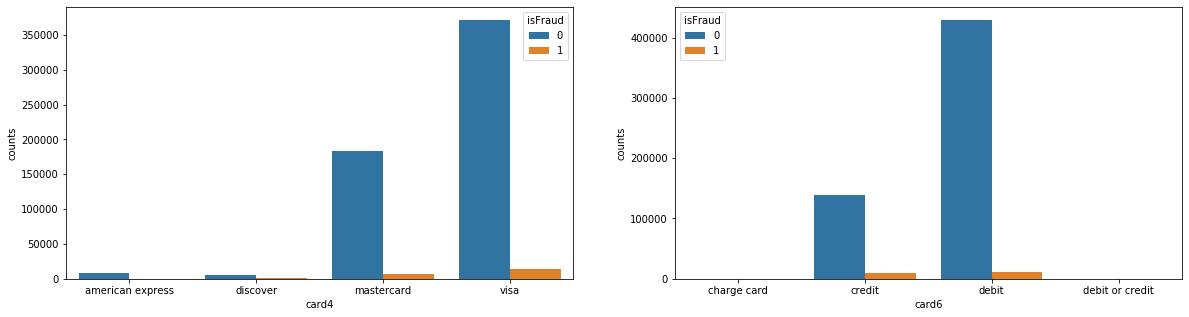

In [21]:
%matplotlib inline
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
sns.barplot(x="card4",y = 'counts', hue='isFraud', data=df_card4)
plt.subplot(1, 2, 2)
sns.barplot(x="card6",y = 'counts', hue='isFraud', data=df_card6)
plt.show()

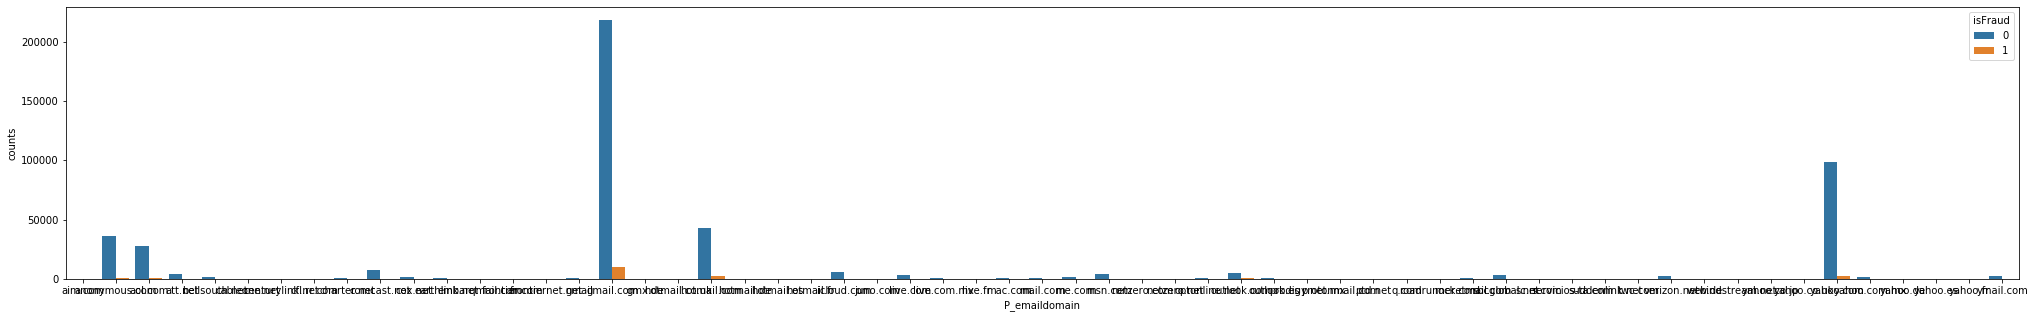

In [22]:
%matplotlib inline 
df_P_emaildomain= train_tran_df[['P_emaildomain','isFraud']].groupby(['P_emaildomain','isFraud']).size().reset_index(name='counts')
plt.figure(figsize = (35,5))
sns.barplot(x="P_emaildomain",y = 'counts', hue='isFraud', data=df_P_emaildomain)
plt.show()

## EAD - Identity data

In [23]:
train_identity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
TransactionID    144233 non-null int64
id_01            144233 non-null float64
id_02            140872 non-null float64
id_03            66324 non-null float64
id_04            66324 non-null float64
id_05            136865 non-null float64
id_06            136865 non-null float64
id_07            5155 non-null float64
id_08            5155 non-null float64
id_09            74926 non-null float64
id_10            74926 non-null float64
id_11            140978 non-null float64
id_12            144233 non-null object
id_13            127320 non-null float64
id_14            80044 non-null float64
id_15            140985 non-null object
id_16            129340 non-null object
id_17            139369 non-null float64
id_18            45113 non-null float64
id_19            139318 non-null float64
id_20            139261 non-null float64
id_21            5159 non-null float64
id_2

In [24]:
%time
# pandas_profiling.ProfileReport(train_identity_df).to_file(output_file="identity.html")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


# Feature Engineering

Let's create some aggregations. There is no logic in them - simply aggregations on top features.



In [0]:
train_df['TransactionAmt_to_mean_card1'] = train_df['TransactionAmt'] / train_df.groupby(['card1'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_mean_card4'] = train_df['TransactionAmt'] / train_df.groupby(['card4'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_std_card1'] = train_df['TransactionAmt'] / train_df.groupby(['card1'])['TransactionAmt'].transform('std')
train_df['TransactionAmt_to_std_card4'] = train_df['TransactionAmt'] / train_df.groupby(['card4'])['TransactionAmt'].transform('std')

test_df['TransactionAmt_to_mean_card1'] = test_df['TransactionAmt'] / test_df.groupby(['card1'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_mean_card4'] = test_df['TransactionAmt'] / test_df.groupby(['card4'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_std_card1'] = test_df['TransactionAmt'] / test_df.groupby(['card1'])['TransactionAmt'].transform('std')
test_df['TransactionAmt_to_std_card4'] = test_df['TransactionAmt'] / test_df.groupby(['card4'])['TransactionAmt'].transform('std')

train_df['id_02_to_mean_card1'] = train_df['id_02'] / train_df.groupby(['card1'])['id_02'].transform('mean')
train_df['id_02_to_mean_card4'] = train_df['id_02'] / train_df.groupby(['card4'])['id_02'].transform('mean')
train_df['id_02_to_std_card1'] = train_df['id_02'] / train_df.groupby(['card1'])['id_02'].transform('std')
train_df['id_02_to_std_card4'] = train_df['id_02'] / train_df.groupby(['card4'])['id_02'].transform('std')

test_df['id_02_to_mean_card1'] = test_df['id_02'] / test_df.groupby(['card1'])['id_02'].transform('mean')
test_df['id_02_to_mean_card4'] = test_df['id_02'] / test_df.groupby(['card4'])['id_02'].transform('mean')
test_df['id_02_to_std_card1'] = test_df['id_02'] / test_df.groupby(['card1'])['id_02'].transform('std')
test_df['id_02_to_std_card4'] = test_df['id_02'] / test_df.groupby(['card4'])['id_02'].transform('std')


train_df['D15_to_mean_card1'] = train_df['D15'] / train_df.groupby(['card1'])['D15'].transform('mean')
train_df['D15_to_mean_card4'] = train_df['D15'] / train_df.groupby(['card4'])['D15'].transform('mean')
train_df['D15_to_std_card1'] = train_df['D15'] / train_df.groupby(['card1'])['D15'].transform('std')
train_df['D15_to_std_card4'] = train_df['D15'] / train_df.groupby(['card4'])['D15'].transform('std')

test_df['D15_to_mean_card1'] = test_df['D15'] / test_df.groupby(['card1'])['D15'].transform('mean')
test_df['D15_to_mean_card4'] = test_df['D15'] / test_df.groupby(['card4'])['D15'].transform('mean')
test_df['D15_to_std_card1'] = test_df['D15'] / test_df.groupby(['card1'])['D15'].transform('std')
test_df['D15_to_std_card4'] = test_df['D15'] / test_df.groupby(['card4'])['D15'].transform('std')

train_df['D15_to_mean_addr1'] = train_df['D15'] / train_df.groupby(['addr1'])['D15'].transform('mean')
train_df['D15_to_mean_addr2'] = train_df['D15'] / train_df.groupby(['addr2'])['D15'].transform('mean')
train_df['D15_to_std_addr1'] = train_df['D15'] / train_df.groupby(['addr1'])['D15'].transform('std')
train_df['D15_to_std_addr2'] = train_df['D15'] / train_df.groupby(['addr2'])['D15'].transform('std')

test_df['D15_to_mean_addr1'] = test_df['D15'] / test_df.groupby(['addr1'])['D15'].transform('mean')
test_df['D15_to_mean_addr2'] = test_df['D15'] / test_df.groupby(['addr2'])['D15'].transform('mean')
test_df['D15_to_std_addr1'] = test_df['D15'] / test_df.groupby(['addr1'])['D15'].transform('std')
test_df['D15_to_std_addr2'] = test_df['D15'] / test_df.groupby(['addr2'])['D15'].transform('std')



In [0]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1

    return dataframe

In [0]:
train_df = id_split(train_df)
test_df = id_split(test_df)

In [0]:
# Encoding - count encoding for both train and test
for feature in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'id_36']:
    train_df[feature + '_count_full'] = train_df[feature].map(pd.concat([train_df[feature], test_df[feature]], ignore_index=True).value_counts(dropna=False))
    test_df[feature + '_count_full'] = test_df[feature].map(pd.concat([train_df[feature], test_df[feature]], ignore_index=True).value_counts(dropna=False))

In [0]:
# Encoding - count encoding separately for train and test
for feature in ['id_01', 'id_31', 'id_33', 'id_36']:
    train_df[feature + '_count_dist'] = train_df[feature].map(train_df[feature].value_counts(dropna=False))
    test_df[feature + '_count_dist'] = test_df[feature].map(test_df[feature].value_counts(dropna=False))

In [0]:
emails = {'gmail': 'google', 'att.net': 'att', 
          'twc.com': 'spectrum', 'scranton.edu': 'other',
          'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 
          'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft',
          'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 
          'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 
          'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 
          'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att',
          'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft',
          'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink',
          'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 
          'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [0]:
for c in ['P_emaildomain', 'R_emaildomain']:
    train_df[c + '_bin'] = train_df[c].map(emails)
    test_df[c + '_bin'] = test_df[c].map(emails)
    
    train_df[c + '_suffix'] = train_df[c].map(lambda x: str(x).split('.')[-1])
    test_df[c + '_suffix'] = test_df[c].map(lambda x: str(x).split('.')[-1])
    
    train_df[c + '_suffix'] = train_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_df[c + '_suffix'] = test_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [0]:
# Label Encodning
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))

 - Dataset has 433338 (73.4%) duplicate rows	Warning
 - C1 is highly skewed (γ1 = 23.95795965)	Skewed
 - C10 is highly correlated with C1 (ρ = 0.9582021807)	Rejected
 - C11 is highly correlated with C10 (ρ = 0.9560557324)	Rejected
 - C12 is highly correlated with C11 (ρ = 0.9156926583)	Rejected
 - C13 has 35460 (6.0%) zeros	Zeros
 - C14 is highly correlated with C11 (ρ = 0.9624645831)	Rejected
 - C2 is highly correlated with C14 (ρ = 0.9361484959)	Rejected
 - C3 is highly skewed (γ1 = 88.94974565)	Skewed
 - C3 has 588111 (99.6%) zeros	Zeros
 - C4 is highly correlated with C2 (ρ = 0.9721337741)	Rejected
 - C5 has 372435 (63.1%) zeros	Zeros
 - C6 is highly correlated with C4 (ρ = 0.9623192744)	Rejected
 - C7 is highly correlated with C2 (ρ = 0.938867028)	Rejected
 - C8 is highly correlated with C7 (ρ = 0.9829833765)	Rejected
 - C9 is highly correlated with C5 (ρ = 0.9257858192)	Rejected
         

 - D1 has 280130 (47.4%) zeros	Zeros
 - D10 has 221930 (37.6%) zeros	Zeros
 - D10 has 76022 (12.9%) missing values	Missing
 - D11 has 112281 (19.0%) zeros	Zeros
 - D11 has 279287 (47.3%) missing values	Missing
 - D15 has 174246 (29.5%) zeros	Zeros
 - D15 has 89113 (15.1%) missing values	Missing
 - 'D2 is highly correlated with D1 (ρ = 0.981311391)	Rejected'
 - D3 has 73094 (12.4%) zeros	Zeros
 - D3 has 262878 (44.5%) missing values	Missing
 - D4 has 166571 (28.2%) zeros	Zeros
 - D4 has 168922 (28.6%) missing values	Missing
 - D5 has 65377 (11.1%) zeros	Zeros
 - D5 has 309841 (52.5%) missing values	Missing

In [0]:
#Lets drop correlated features
correlated_cols = list(set(train_tran_df.loc[:, 'C1':'C14'].columns) - set(['C1','C13','C3','C5']))
train_df.drop(correlated_cols,axis = 1,inplace = True)
test_df.drop(correlated_cols,axis = 1,inplace = True)

train_df.drop(['D2'],axis = 1,inplace = True)
test_df.drop(['D2'],axis = 1,inplace = True)

- geting Date features

In [0]:
train_df['Transaction_dow'] = np.floor((train_df['TransactionDT'] / (3600 * 24)-1) % 7)#day of a week from some referance day
test_df['Transaction_dow'] = np.floor((test_df['TransactionDT'] / (3600 * 24)-1) % 7)#day of a week from some referance day
test_df['Transaction_hour'] = np.floor(test_df['TransactionDT'] / 3600) % 24 # hour of the day
train_df['Transaction_hour'] = np.floor(train_df['TransactionDT'] / 3600) % 24 # hour of the day

In [35]:
pd.crosstab(train_df['Transaction_dow'],train_df.isFraud).transpose()

Transaction_dow,0.0,1.0,2.0,3.0,4.0,5.0,6.0
isFraud,,,,,,,
0,94952,76871,67720,82746,82012,82410,83166
1,3550,2963,2503,2687,2803,2946,3211


In [36]:
pd.crosstab(train_df['Transaction_hour'],train_df.isFraud).transpose()

Transaction_hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
isFraud,,,,,,,,,,,,,,,,,,,,,,,,
0,36609,31770,25730,20005,14069,9019,5540,3311,2350,2256,3434,6562,12072,19850,27642,32999,37556,39439,40172,40652,40350,40225,39794,38471
1,1186,1027,1002,797,770,682,467,393,241,223,193,265,379,465,686,860,1142,1284,1467,1463,1432,1416,1345,1478


In [0]:
# New feature - log of transaction amount.
train_df['TransactionAmt_Log'] = np.log(train_df['TransactionAmt'])
test_df['TransactionAmt_Log'] = np.log(test_df['TransactionAmt'])


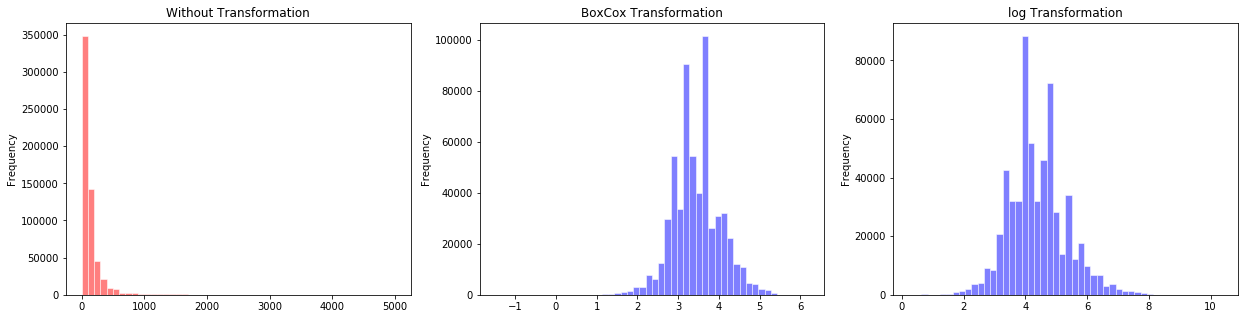

In [38]:
%matplotlib inline
plt.subplot(1, 3, 1)
(train_df.TransactionAmt).plot.hist(bins=50, figsize=(21, 5),color = 'red',alpha = 0.5 ,edgecolor = 'white', range = [0, 5000],title = 'Without Transformation')

plt.subplot(1, 3, 2)
pd.Series(boxcox(train_df.TransactionAmt)[0]).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'BoxCox Transformation')

plt.subplot(1, 3, 3)
np.log(train_df.TransactionAmt+1).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'log Transformation')

plt.show()

In [0]:
# New feature - decimal part of the transaction amount.
train_df['TransactionAmt_decimal'] = ((train_df['TransactionAmt'] - train_df['TransactionAmt'].astype(int)) * 1000).astype(int)
test_df['TransactionAmt_decimal'] = ((test_df['TransactionAmt'] - test_df['TransactionAmt'].astype(int)) * 1000).astype(int)

In [0]:
# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C1', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train_df[feature] = train_df[f1].astype(str) + '_' + train_df[f2].astype(str)
    test_df[feature] = test_df[f1].astype(str) + '_' + test_df[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train_df[feature].astype(str).values) + list(test_df[feature].astype(str).values))
    train_df[feature] = le.transform(list(train_df[feature].astype(str).values))
    test_df[feature] = le.transform(list(test_df[feature].astype(str).values))

In [41]:
#Drop the columns with more than 90% nulls
df = pd.DataFrame(train_df.isna().sum()/train_df.shape[0]*100,columns= ['null_percent'])
print(df.head())
print("*************"+"\n\n")
df = df[df.null_percent<90]
final_columns = df.index
print('#columns in raw data: ',len(train_df.columns))
print("#columns: ",len(final_columns))

                null_percent
TransactionID            0.0
isFraud                  0.0
TransactionDT            0.0
TransactionAmt           0.0
ProductCD                0.0
*************


#columns in raw data:  477
#columns:  467


In [0]:
train_df = train_df[final_columns] 

In [43]:
for i in train_df.columns:
    print(i)
    print(train_df[i].unique())
    print("\n\n"+"*******************")

TransactionID
[2987000 2987001 2987002 ... 3577537 3577538 3577539]


*******************
isFraud
[0 1]


*******************
TransactionDT
[   86400    86401    86469 ... 15811079 15811088 15811131]


*******************
TransactionAmt
[  68.5    29.     59.   ...  557.54 1659.95  400.78]


*******************
ProductCD
[4 1 0 3 2]


*******************
card1
[13926  2755  4663 ... 13166  8767 18038]


*******************
card2
[ nan 404. 490. 567. 514. 555. 360. 100. 111. 352. 375. 418. 303. 314.
 543. 583. 148. 321. 269. 361. 272. 399. 569. 453. 417. 512. 545. 266.
 114. 481. 452. 547. 383. 170. 343. 556. 285. 562. 302. 264. 558. 500.
 396. 103. 206. 143. 243. 476. 199. 174. 423. 446. 492. 523. 440. 528.
 161. 535. 354. 117. 455. 325. 158. 268. 122. 479. 147. 215. 480. 265.
 388. 408. 309. 415. 414. 437. 104. 225. 101. 134. 586. 191. 491. 369.
 322. 494. 532. 313. 474. 324. 475. 298. 429. 432. 553. 566. 599. 296.
 251. 310. 242. 204. 250. 270. 346. 316. 194. 587. 390. 135. 536. 254.

# Prepare data for Model - without SMOTE

In [0]:
X = train_df.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT','TransactionID'], axis=1)
y = train_df.sort_values('TransactionDT')['isFraud']

X_test = test_df.drop(['TransactionDT','TransactionID'], axis=1)

del train_df, test_df



In [0]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          # 'device' = 'gpu',
          #  'gpu_platform_id' = 0,
          #  'gpu_device_id' = 0
          
}


In [0]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0
recallscore = 0

In [0]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

In [48]:
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    print("step1")
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    print("step2")
    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    print("step3")
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_pred_valid_class =y_pred_valid.copy()
    y_pred_valid_class[np.where(y_pred_valid>=.5)]=1
    y_pred_valid_class[np.where(y_pred_valid<=.5)]=0
    print("step4")
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    print(f"Fold {fold_n + 1} | recall: {recall_score(y_valid, y_pred_valid_class)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    recallscore += recall_score(y_valid, y_pred_valid_class) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    del X_train, X_valid, y_train, y_valid
    
print(f"\nMean AUC = {score}")
print(f"\nMean recall = {recallscore}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")  


step1
step2
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.953928	valid_1's auc: 0.884112
[400]	training's auc: 0.975281	valid_1's auc: 0.898824
[600]	training's auc: 0.988319	valid_1's auc: 0.908864
[800]	training's auc: 0.994288	valid_1's auc: 0.914206
[1000]	training's auc: 0.99722	valid_1's auc: 0.917115
[1200]	training's auc: 0.998683	valid_1's auc: 0.918801
[1400]	training's auc: 0.999364	valid_1's auc: 0.91985
[1600]	training's auc: 0.999687	valid_1's auc: 0.92044
[1800]	training's auc: 0.99985	valid_1's auc: 0.921092
[2000]	training's auc: 0.999927	valid_1's auc: 0.921192
[2200]	training's auc: 0.999966	valid_1's auc: 0.92144
[2400]	training's auc: 0.999984	valid_1's auc: 0.921812
[2600]	training's auc: 0.999992	valid_1's auc: 0.921919
[2800]	training's auc: 0.999996	valid_1's auc: 0.921925
[3000]	training's auc: 0.999998	valid_1's auc: 0.922119
[3200]	training's auc: 0.999999	valid_1's auc: 0.922027
[3400]	training's auc: 1	valid_1's auc

In [49]:
print(f"Mean AUC = {score}")
print(f"Mean recall = {recallscore}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")  

Mean AUC = 0.9350569940681046
Mean recall = 0.3937647375543034
Out of folds AUC = 0.9354592346589835


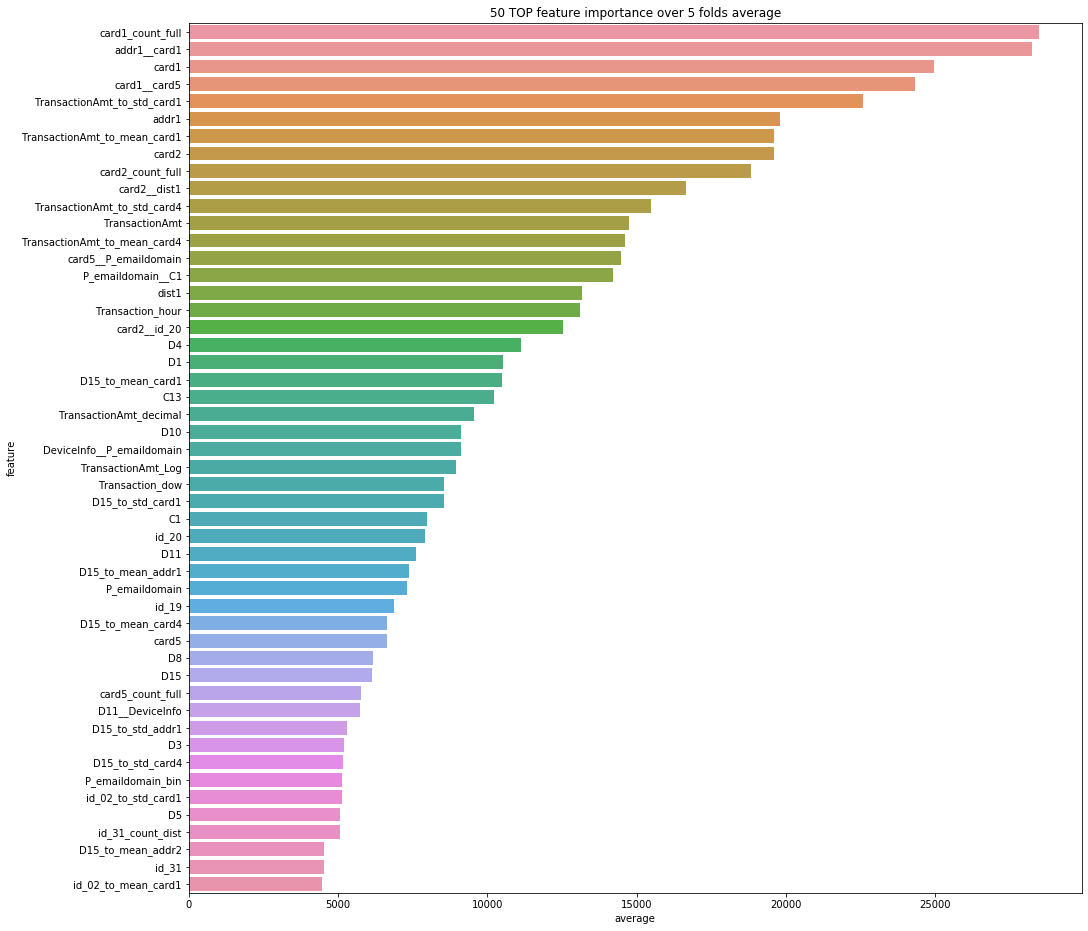

In [50]:

feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

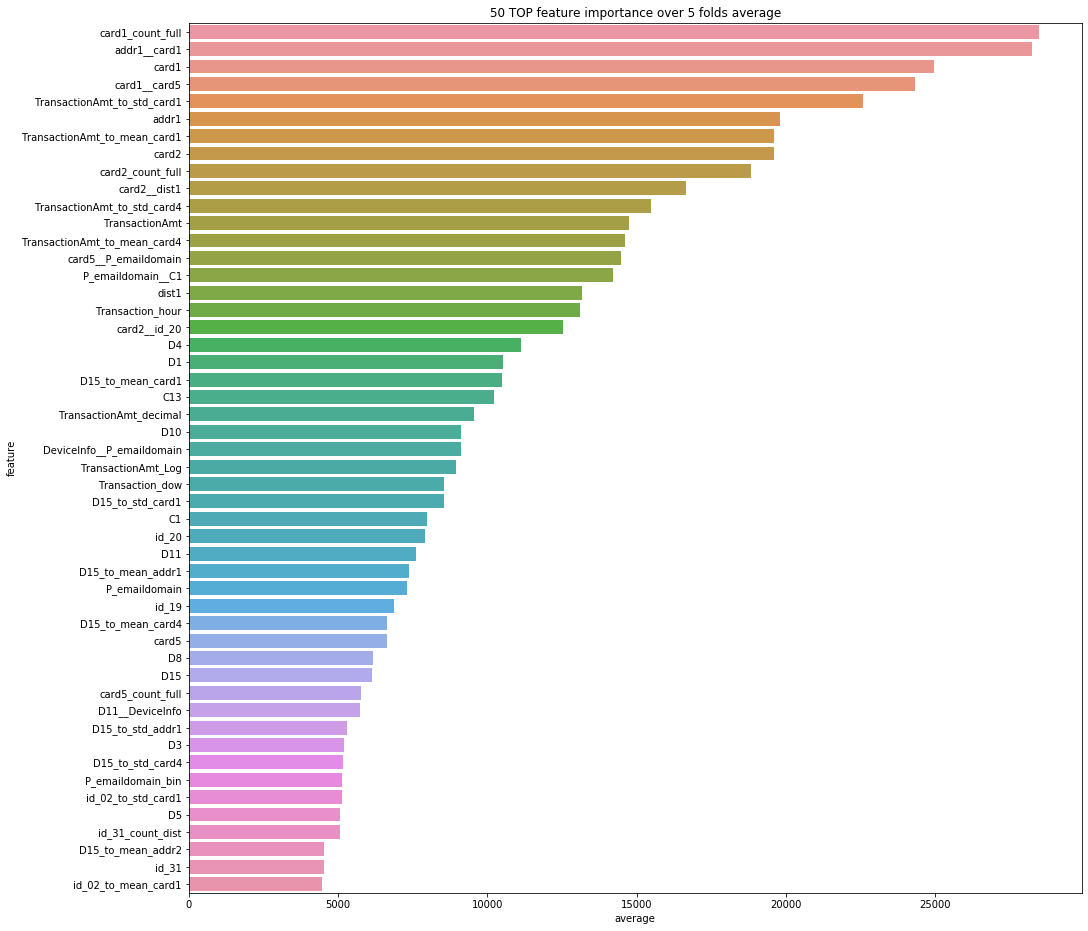

In [51]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [0]:
positive_samples = sum(y =1)
total_samples = len(y)
scale_pos_weight = 100 - ( [positive_samples / total_samples ] * 100 )
scale_pos_weight = 100 - ( [ 143540 / 57000000 ] * 100 ) 
scale_pos_weight = 99.74



# T - no. of total samples
# P - no. of positive samples
# scale_pos_weight = percent of negative / percent of positive
# which translates to:
# scale_pos_weight = (100*(T-P)/T) / (100*P/T)
# which further simplifies to beautiful:
scale_pos_weight = T/P - 1

TypeError: ignored

## SMOTE(Synthetic Minority Over-sampling Technique)
 - `Generate new Instances of minority class`

In [0]:
# Transaction Amount vs fraud

X_Axis= widgets.Dropdown(options= numericCols)
Y_Axis= widgets.Dropdown(options= numericCols)

def plot_scatter(X_Axis,Y_Axis):                            
  plt.figure(figsize = (20,5))
  plt.subplot(1, 2, 1)
  sns.scatterplot(x = train_tran_df[X_Axis],y = train_tran_df[Y_Axis],hue = train_tran_df.isFraud)
  plt.subplot(1, 2, 2)
  sns.scatterplot(x = train_tran_df[Y_Axis],y =train_tran_df[X_Axis],hue = train_tran_df.isFraud)

In [0]:
%matplotlib inline
interactive(plot_scatter, X_Axis=X_Axis,Y_Axis=Y_Axis)

interactive(children=(Dropdown(description='X_Axis', index=3, options=('TransactionID', 'isFraud', 'Transactio…

In [0]:
X_Axis = widgets.Dropdown(options= numericCols)
BC_lambda = widgets.Dropdown(options= [0,-1,-2,-3,None])
def plot_hist_vs_transformed_hist(X_Axis,BC_lambda=BC_lambda):                            
  plt.subplot(1, 3, 1)
  (train_tran_df[X_Axis]).plot.hist(bins=50, figsize=(21, 5),color = 'red',alpha = 0.5 ,edgecolor = 'white',title = 'Without Transformation')
  
  plt.subplot(1, 3, 2)
  pd.Series(boxcox(train_tran_df[X_Axis],BC_lambda)[0]).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'BoxCox Transformation')
  plt.subplot(1, 3, 3)
  np.log(train_tran_df[X_Axis]+1).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'log Transformation')
  plt.show()

In [0]:
# %matplotlib inline
# interactive(plot_hist_vs_transformed_hist, X_Axis=X_Axis,BC_lambda=BC_lambda)



interactive(children=(Dropdown(description='X_Axis', options=('TransactionID', 'isFraud', 'TransactionDT', 'Tr…

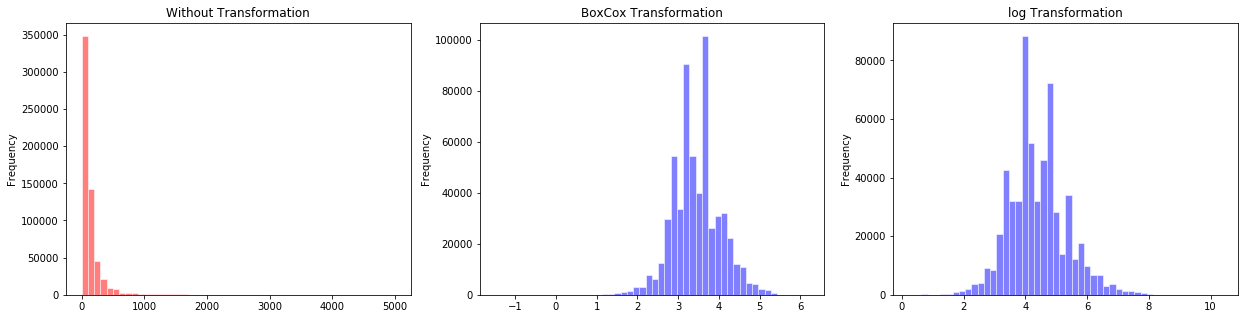

In [0]:
%matplotlib inline
plt.subplot(1, 3, 1)
(train_tran_df.TransactionAmt).plot.hist(bins=50, figsize=(21, 5),color = 'red',alpha = 0.5 ,edgecolor = 'white', range = [0, 5000],title = 'Without Transformation')

plt.subplot(1, 3, 2)
pd.Series(boxcox(train_tran_df.TransactionAmt)[0]).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'BoxCox Transformation')

plt.subplot(1, 3, 3)
np.log(train_tran_df.TransactionAmt+1).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'log Transformation')

plt.show()

In [0]:
#what is productcd affect on fraud
pd.crosstab(train_tran_df.ProductCD,train_tran_df.isFraud).transpose().apply(lambda r: r/r.sum(), axis=0)

ProductCD,C,H,R,S,W
isFraud,,,,,
0,0.883127,0.952338,0.962174,0.941004,0.979601
1,0.116873,0.047662,0.037826,0.058996,0.020399


In [0]:

train_tran_df[numericCols].describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,Transaction_dow,Transaction_hour
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,5902

In [0]:
#drop Columns with more than 70% na data
(train_tran_df.isna().sum()/train_tran_df.shape[0])*100[0]


TransactionID        0.000000
isFraud              0.000000
TransactionDT        0.000000
TransactionAmt       0.000000
ProductCD            0.000000
card1                0.000000
card2                1.512683
card3                0.265012
card4                0.000000
card5                0.721204
card6                0.000000
addr1               11.126427
addr2               11.126427
dist1               59.652352
dist2               93.628374
P_emaildomain        0.000000
R_emaildomain        0.000000
C1                   0.000000
C2                   0.000000
C3                   0.000000
C4                   0.000000
C5                   0.000000
C6                   0.000000
C7                   0.000000
C8                   0.000000
C9                   0.000000
C10                  0.000000
C11                  0.000000
C12                  0.000000
C13                  0.000000
C14                  0.000000
D1                   0.214888
D2                  47.549192
D3        

In [0]:
train_tran_df[categoricalCols] = train_tran_df[categoricalCols].replace({ np.nan:'missing'})
train_tran_df[numericCols] = train_tran_df[numericCols].replace({ np.nan:-1})

KeyboardInterrupt: ignored

In [0]:

Feature= widgets.Dropdown(options= numericCols)

def plotit(Feature):                            
    
    %matplotlib inline
    
    plt.figure(figsize = (10,5))
    sns.scatterplot(x = train_tran_df[Feature],y = train_tran_df.isFraud,hue = train_tran_df.isFraud)

    flush_figures()
                            
interactive(plotit, Feature=Feature)

interactive(children=(Dropdown(description='Feature', options=('TransactionID', 'isFraud', 'TransactionDT', 'T…

In [0]:
# Feature engineering 

In [0]:
#Time and day are imprtant factors to identify 
train_tran_df['Transaction_dow'] = np.floor((train_tran_df['TransactionDT'] / (3600 * 24)-1) % 7)#day of a week from some referance day
train_tran_df['Transaction_hour'] = np.floor(train_tran_df['TransactionDT'] / 3600) % 24 # hour of the day

In [0]:
day_fraud = pd.crosstab(train_tran_df['Transaction_dow'],train_tran_df.isFraud).transpose()
day_fraud

Transaction_dow,0.0,1.0,2.0,3.0,4.0,5.0,6.0
isFraud,,,,,,,
0,94952,76871,67720,82746,82012,82410,83166
1,3550,2963,2503,2687,2803,2946,3211


In [0]:
pd.crosstab(train_tran_df['Transaction_hour'],train_tran_df.isFraud).transpose()

Transaction_hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
isFraud,,,,,,,,,,,,,,,,,,,,,,,,
0,36609,31770,25730,20005,14069,9019,5540,3311,2350,2256,3434,6562,12072,19850,27642,32999,37556,39439,40172,40652,40350,40225,39794,38471
1,1186,1027,1002,797,770,682,467,393,241,223,193,265,379,465,686,860,1142,1284,1467,1463,1432,1416,1345,1478
